In [1]:
import pandas as pd

df_songs = pd.read_csv("billboard/Billboard Charts/hot100.csv", sep="\t")
df_songs

,date,title,artist,peakPos,lastPos,weeks,rank
0,2018-08-25,In My Feelings,Drake,1,1,7,1
1,2018-08-25,Girls Like You,Maroon 5 Featuring Cardi B,2,2,12,2
2,2018-08-25,I Like It,"Cardi B, Bad Bunny & J Balvin",1,3,19,3
3,2018-08-25,FEFE,6ix9ine Featuring Nicki Minaj & Murda Beatz,3,5,4,4
4,2018-08-25,Better Now,Post Malone,5,6,16,5
...,...,...,...,...,...,...,...
313395,1958-08-11,Down In Virginia,Jimmy Reed,96,0,0,96
313396,1958-08-11,Sunday Barbecue,Tennessee Ernie Ford,97,0,0,97
313397,1958-08-11,Gotta Have Rain,Eydie Gorme,74,74,2,98
313398,1958-08-11,Nothing In The World,Nat King Cole,99,0,0,99


In [2]:
def process_artists(input_str):
    liste_art = input_str.split()

    outp_list = []
    current_art = ""
    for art in liste_art:
        if art == "&" and current_art != "":
            outp_list.append(current_art)
            current_art = ""
        elif (art == "Featuring" or art == "featuring" or art == "Feat.") and current_art != "":
            outp_list.append(current_art)
            current_art = ""
        elif "," in art and art[len(art)-1] == ",":
            outp_list.append(current_art + " " + art[:-1])
            current_art = ""
        elif current_art == "":
            current_art = art
        else:
            current_art = current_art + " " + art

    if current_art:  # Append the last artist if there's any remaining
        outp_list.append(current_art)

    return outp_list

In [3]:
df_songs['artist'] = df_songs['artist'].apply(process_artists)
df_songs

,date,title,artist,peakPos,lastPos,weeks,rank
0,2018-08-25,In My Feelings,[Drake],1,1,7,1
1,2018-08-25,Girls Like You,"[Maroon 5, Cardi B]",2,2,12,2
2,2018-08-25,I Like It,"[Cardi B, Bad Bunny, J Balvin]",1,3,19,3
3,2018-08-25,FEFE,"[6ix9ine, Nicki Minaj, Murda Beatz]",3,5,4,4
4,2018-08-25,Better Now,[Post Malone],5,6,16,5
...,...,...,...,...,...,...,...
313395,1958-08-11,Down In Virginia,[Jimmy Reed],96,0,0,96
313396,1958-08-11,Sunday Barbecue,[Tennessee Ernie Ford],97,0,0,97
313397,1958-08-11,Gotta Have Rain,[Eydie Gorme],74,74,2,98
313398,1958-08-11,Nothing In The World,[Nat King Cole],99,0,0,99


merge nun mit musicoset für songs

In [4]:
df_songs_musico = pd.read_csv("../MusicOSet/musicoset_metadata/songs.csv", delimiter="\t")
df_tracks_musico = pd.read_csv("../MusicOSet/musicoset_metadata/tracks.csv", delimiter="\t")
df_merged_songs_musico = pd.merge(df_songs_musico, df_tracks_musico, on='song_id', how='inner')
df_merged_songs_musico.rename(columns={'song_name': 'title'}, inplace=True)
df_merged_songs_musico["artist"] = df_merged_songs_musico["artists"].apply(lambda x: tuple(list(eval(x).values()))) 
df_songs["artist"] = df_songs["artist"].apply(tuple) 
df_merged_songs_all = pd.merge(df_songs, df_merged_songs_musico, on=["title", "artist"], how='inner')
df_merged_songs_all["artist"] = df_merged_songs_all["artist"].apply(list)
df_merged_songs_all

,date,title,artist,peakPos,lastPos,weeks,rank,song_id,billboard,artists,popularity,explicit,song_type,album_id,track_number,release_date,release_date_precision
0,2018-08-25,In My Feelings,[Drake],1,1,7,1,2G7V7zsVDxg1yRsu7Ew9RJ,"('In My Feelings', 'Drake')",{'3TVXtAsR1Inumwj472S9r4': 'Drake'},82,True,Solo,1ATL5GLyefJaxhQzSPVrLX,9,2018-06-29,day
1,2018-08-18,In My Feelings,[Drake],1,1,6,1,2G7V7zsVDxg1yRsu7Ew9RJ,"('In My Feelings', 'Drake')",{'3TVXtAsR1Inumwj472S9r4': 'Drake'},82,True,Solo,1ATL5GLyefJaxhQzSPVrLX,9,2018-06-29,day
2,2018-08-11,In My Feelings,[Drake],1,1,5,1,2G7V7zsVDxg1yRsu7Ew9RJ,"('In My Feelings', 'Drake')",{'3TVXtAsR1Inumwj472S9r4': 'Drake'},82,True,Solo,1ATL5GLyefJaxhQzSPVrLX,9,2018-06-29,day
3,2018-08-04,In My Feelings,[Drake],1,1,4,1,2G7V7zsVDxg1yRsu7Ew9RJ,"('In My Feelings', 'Drake')",{'3TVXtAsR1Inumwj472S9r4': 'Drake'},82,True,Solo,1ATL5GLyefJaxhQzSPVrLX,9,2018-06-29,day
4,2018-07-28,In My Feelings,[Drake],1,1,3,1,2G7V7zsVDxg1yRsu7Ew9RJ,"('In My Feelings', 'Drake')",{'3TVXtAsR1Inumwj472S9r4': 'Drake'},82,True,Solo,1ATL5GLyefJaxhQzSPVrLX,9,2018-06-29,day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150849,1963-11-23,Be Mad Little Girl,[Bobby Darin],90,0,0,90,33dpZRUyyjAvGkS8xDJkkO,"('Be Mad Little Girl', 'Bobby Darin')",{'0EodhzA6yW1bIdD5B4tcmJ': 'Bobby Darin'},1,False,Solo,0osnE1kZ7fPfSf41qP3AZN,9,1989-01-01,day
150850,1964-01-04,I'll Search My Heart,[Johnny Mathis],90,90,4,97,7Gk1QKi2BAZCnrYlrYEDjC,"(""I'll Search My Heart"", 'Johnny Mathis')",{'21LGsW7bziR4Ledx7WZ1Wf': 'Johnny Mathis'},3,False,Solo,2eWGEDWDdJHHlBtDqVvRSN,8,2015-09-25,day
150851,1963-12-28,I'll Search My Heart,[Johnny Mathis],90,94,3,90,7Gk1QKi2BAZCnrYlrYEDjC,"(""I'll Search My Heart"", 'Johnny Mathis')",{'21LGsW7bziR4Ledx7WZ1Wf': 'Johnny Mathis'},3,False,Solo,2eWGEDWDdJHHlBtDqVvRSN,8,2015-09-25,day
150852,1963-12-21,I'll Search My Heart,[Johnny Mathis],94,95,2,94,7Gk1QKi2BAZCnrYlrYEDjC,"(""I'll Search My Heart"", 'Johnny Mathis')",{'21LGsW7bziR4Ledx7WZ1Wf': 'Johnny Mathis'},3,False,Solo,2eWGEDWDdJHHlBtDqVvRSN,8,2015-09-25,day


In [5]:
df_artists = pd.read_csv("billboard/Billboard Charts/top100_artists.csv", sep="\t")
artist_set = set(df_artists["artist"])
len(artist_set)

1135

In [6]:
all_artists_names = set(df_songs["artist"].iloc[0])
for art in df_songs["artist"].iloc[1:]:
    all_artists_names.update(art)
    
len(all_artists_names)

8432

da Daten bezüglich der Songs und Artists fehlen mergen wir diese mit dem Musicoset


In [7]:
df_artists = pd.read_csv("../MusicOSet/musicoset_metadata/artists.csv", delimiter="\t")
df_artists

,artist_id,name,followers,popularity,artist_type,main_genre,genres,image_url
0,66CXWjxzNUsdJxJ2JdwvnR,Ariana Grande,34554242.0,96,singer,dance pop,"['dance pop', 'pop', 'post-teen pop']",https://i.scdn.co/image/b1dfbe843b0b9f54ab2e58...
1,26VFTg2z8YR0cCuwLzESi2,Halsey,7368242.0,90,singer,dance pop,"['dance pop', 'electropop', 'etherpop', 'indie...",https://i.scdn.co/image/22a5f3d8c42bc7cb55215e...
2,0Y5tJX1MQlPlqiwlOH1tJY,Travis Scott,6313709.0,94,rapper,pop,"['pop', 'pop rap', 'rap']",https://i.scdn.co/image/dc5eba5e032c2e5bc4d42c...
3,246dkjvS1zLTtiykXe5h60,Post Malone,16737002.0,96,rapper,dfw rap,"['dfw rap', 'pop', 'rap']",https://i.scdn.co/image/f9d8b742b66609f12da023...
4,1zNqQNIdeOUZHb8zbZRFMX,Swae Lee,483032.0,89,singer,trap music,['trap music'],https://i.scdn.co/image/a177469870b41f7e17e3b5...
...,...,...,...,...,...,...,...,...
11513,7vyRisgvM6Wm0Pnp0qXx6m,Sweeney Todd,634.0,19,-,classic canadian rock,['classic canadian rock'],https://i.scdn.co/image/47166b7afefd590ce85086...
11514,2Uh4UmiQhrrElbrvJVH0dT,Brooklyn Dreams,318.0,32,band,-,[],https://i.scdn.co/image/bae9c82929c50d2dadb1ec...
11515,1VGFS4UGLOAxlMGqzcqHG1,PMD,1405.0,32,-,-,[],https://i.scdn.co/image/926172541a4dff5dca6bce...
11516,3Se8xpgCBmfXVnZqRSRRH9,The Tribute Co.,274.0,21,-,-,[],https://i.scdn.co/image/d4e9b2299fc5cbe4332251...


In [8]:
all_artists_names_df = pd.DataFrame(all_artists_names, columns=["name"])
all_artists_names_df

,name
0,NF
1,Canibus
2,Roll Double Bubble
3,Dakota
4,Miley Cyrus
...,...
8427,Timex Social Club
8428,Van McCoy And The Soul City Symphony
8429,Faithless
8430,Meja


In [9]:
merged_df = pd.merge(all_artists_names_df, df_artists, on='name', how='inner')
merged_df

,name,artist_id,followers,popularity,artist_type,main_genre,genres,image_url
0,NF,6fOMl44jA4Sp5b9PpYCkzz,2256060.0,90,singer,hip hop,"['hip hop', 'rap']",https://i.scdn.co/image/55db20d7c49bdcf5216247...
1,Canibus,2lQvoGjN6jJfsAkaywtgrB,46773.0,43,rapper,battle rap,"['battle rap', 'east coast hip hop', 'hardcore...",https://i.scdn.co/image/826ea3ac8c67b0b10f4037...
2,Miley Cyrus,5YGY8feqx7naU7z4HrwZM6,9615219.0,87,singer,dance pop,"['dance pop', 'pop', 'post-teen pop']",https://i.scdn.co/image/b5079187578650ea27fba0...
3,Gavin DeGraw,5DYAABs8rkY9VhwtENoQCz,910431.0,70,singer,acoustic pop,"['acoustic pop', 'neo mellow', 'pop', 'pop rock']",https://i.scdn.co/image/80f2e66ec853cf0974a870...
4,R.E.M.,4KWTAlx2RvbpseOGMEmROg,1984742.0,76,band,alternative rock,"['alternative rock', 'permanent wave', 'pop ro...",https://i.scdn.co/image/3ef4b92f85f8d7b902dd2b...
...,...,...,...,...,...,...,...,...
4957,Cisco Adler,23apFYuBTpFemqLDn8ViLW,12063.0,57,-,indie pop rap,['indie pop rap'],https://i.scdn.co/image/a2a7450e4c67353fea573b...
4958,British Lions,79EQ2MmIK2wQakeotwFuNF,717.0,6,-,-,[],https://i.scdn.co/image/2a8d966a452a6b473bd356...
4959,Timex Social Club,1C0HVpji7xDIdGbnsdUwCt,2997.0,35,band,-,[],https://i.scdn.co/image/c248effd764b50f14a28e4...
4960,Faithless,5T4UKHhr4HGIC0VzdZQtAE,330083.0,62,band,big beat,"['big beat', 'downtempo', 'electronic']",https://i.scdn.co/image/21ab7a9b6caa1e6cc17e70...


In [10]:
import networkx as nx

#reduziere auf artists von Liste
#all_artists_names = all_artists_names.intersection(artist_set)
all_artists_names = set(merged_df["name"])

G = nx.Graph()

collab_counter = 0

for _, row in merged_df.iterrows():
    artist_name = str(row["name"])
    #artist_info = df_artists[df_artists["artist_id"] == name_art_cur]
    popularity = int(row['popularity'])
    followers = float(row["followers"])
    # Filter out artists who are not successful
    #if popularity >= 70 and followers >= 1_000_000:
    G.add_node(artist_name, id=row["artist_id"], popularity=popularity, followers=followers, genres=row["genres"])
    #G.add_node(name_art_cur)

for _, row in df_merged_songs_all.iterrows():
    artist_name = list(row["artist"])
    # Filter out songs that do not have more than one artist in their execution
    if len(artist_name) > 1:
        for i in range(len(artist_name)):
            for j in range(i+1, len(artist_name)):
                artist_id_1 = artist_name[i]
                artist_id_2 = artist_name[j]
                #prüfe ob die Artists Teil der Interessanten Menge sind
                if artist_id_1 in all_artists_names and artist_id_2 in all_artists_names:
                    # Check if the edge already exists
                    if G.has_edge(artist_id_1, artist_id_2):
                        # If the edge already exists, increment the weight by 1
                        G[artist_id_1][artist_id_2]['weight'] += 1
                        collab_counter += 1
                    else:
                        # Add a new edge with weight 1
                        collab_counter += 1
                        G.add_edge(artist_id_1, artist_id_2, weight=1, song_id=row["song_id"], song_name=row["title"], explicit=row["explicit"], popularity=row["popularity"], release_date=row["release_date"], release_date_precision=row["release_date_precision"])
    else:
        artist_id = artist_name[0]
        #prüfe ob die Artists Teil der Interessanten Menge sind
        if artist_id in all_artists_names:
            # Model songs that do not have more than one artist in their execution as self-loops on the artist’s node
            if G.has_edge(artist_id, artist_id):
                # If the edge already exists, increment the weight by 1
                G[artist_id][artist_id]['weight'] += 1
            else:
                # Add a new edge with weight 1
                G.add_edge(artist_id, artist_id, weight=1, song_id=row["song_id"], song_name=row["title"], explicit=row["explicit"], popularity=row["popularity"], release_date=row["release_date"], release_date_precision=row["release_date_precision"])


In [11]:
"""import matplotlib.pyplot as plt

# Draw the graph
nx.draw(G, with_labels=False, node_color='skyblue', node_size=1, edge_color='black', linewidths=1, font_size=15)

# Display the plot
plt.savefig("network.png")
plt.show()"""

'import matplotlib.pyplot as plt\n\n# Draw the graph\nnx.draw(G, with_labels=False, node_color=\'skyblue\', node_size=1, edge_color=\'black\', linewidths=1, font_size=15)\n\n# Display the plot\nplt.savefig("network.png")\nplt.show()'

## About the Network

comments:
- use names instead
- use other direction
- use only popular artists


In [12]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)
print("Number of collabs:", collab_counter)


Number of nodes: 4882
Number of edges: 3551
Number of collabs: 1772


In [13]:
node_list = list(G.nodes())
edge_list = list(G.edges())
#print("List of nodes:", node_list)
#print("List of edges:", edge_list)

In [14]:
degree = G.degree()
print("Degree of nodes:", degree)


Degree of nodes: [('NF', 2), ('Canibus', 0), ('Miley Cyrus', 2), ('Gavin DeGraw', 2), ('R.E.M.', 2), ('A.L.T. And The Lost Civilization', 2), ('Quicksilver Messenger Service', 2), ('Hole', 2), ('EMF', 2), ('Javier Colon', 0), ('Clean Bandit', 0), ('Gavin Christopher', 2), ('Kaskade', 0), ('Michael Peterson', 2), ('Mudvayne', 2), ('Saving Abel', 2), ('The Soulful Strings', 2), ('Hannah Montana', 2), ('Lou Johnson', 0), ('Shanice', 2), ('Wilson Phillips', 2), ('Andy Griggs', 2), ('Claudia Leitte', 0), ('Jennifer Love Hewitt', 2), ('Solange', 0), ('Heart', 2), ('Mickey Lee Lane', 2), ('Bill Quateman', 0), ('Zac Brown Band', 2), ('Migos', 2), ('Johnny Cash', 2), ('The Charlie Daniels Band', 2), ('Cashmere Cat', 0), ('The Parade', 2), ('A Taste Of Honey', 2), ('Ritchie Valens', 0), ('Jane Morgan', 0), ('Conway Twitty', 2), ('The Gibson Brothers', 2), ('Travie McCoy', 0), ('Ian Thomas', 2), ('The Marketts', 2), ('Babyface', 2), ('Ronnie Hawkins', 0), ('Angelica', 2), ('Beverly Bremers', 2), 

In [15]:
density = nx.density(G)
print("Graph density:", density)


Graph density: 0.00029803967780156666


## Calculate the Metrics


In [16]:
# (1) Interaction (degree and weighted degree)
for node, degree in G.degree():
    G.nodes[node]['degree'] = degree
for node, degree in G.degree(weight='weight'):
    G.nodes[node]['weighted_degree'] = degree

# (2) Distance (closeness and eccentricity)
closeness = nx.closeness_centrality(G)
for node, closeness_val in closeness.items():
    G.nodes[node]['closeness'] = closeness_val

# Eccentricity is not defined for disconnected graphs, so we need to handle that
if nx.is_connected(G):
    eccentricity = nx.eccentricity(G)
    for node, eccentricity_val in eccentricity.items():
        G.nodes[node]['eccentricity'] = eccentricity_val

# (3) Similarity (clustering coefficient)
clustering = nx.clustering(G)
for node, clustering_val in clustering.items():
    G.nodes[node]['clustering'] = clustering_val

# (4) Influence (betweenness and eigenvector)
betweenness = nx.betweenness_centrality(G)
for node, betweenness_val in betweenness.items():
    G.nodes[node]['betweenness'] = betweenness_val

eigenvector = nx.eigenvector_centrality(G)
for node, eigenvector_val in eigenvector.items():
    G.nodes[node]['eigenvector'] = eigenvector_val

## Clustering


now try clustering based on metrics:

In [17]:
import pandas as pd

# Assuming G is your NetworkX graph

# Extract nodes and their attributes from the graph
nodes_with_attributes = [(node, G.nodes[node]) for node in G.nodes()]

# Create a DataFrame from the nodes and their attributes
df_nodes = pd.DataFrame(nodes_with_attributes, columns=['Node', 'Attributes'])

# Normalize the 'Attributes' column to expand it into separate columns
df_attributes = pd.json_normalize(df_nodes['Attributes'])

# Combine the original 'Node' column with the expanded attributes
df_nodes = pd.concat([df_nodes['Node'], df_attributes], axis=1)

# Display the DataFrame
df_nodes


,Node,id,popularity,followers,genres,degree,weighted_degree,closeness,clustering,betweenness,eigenvector
0,NF,6fOMl44jA4Sp5b9PpYCkzz,90,2256060.0,"['hip hop', 'rap']",2,62,0.0,0.0,0.0,1.929859e-18
1,Canibus,2lQvoGjN6jJfsAkaywtgrB,43,46773.0,"['battle rap', 'east coast hip hop', 'hardcore...",0,0,0.0,0.0,0.0,1.755196e-30
2,Miley Cyrus,5YGY8feqx7naU7z4HrwZM6,87,9615219.0,"['dance pop', 'pop', 'post-teen pop']",2,412,0.0,0.0,0.0,1.929859e-18
3,Gavin DeGraw,5DYAABs8rkY9VhwtENoQCz,70,910431.0,"['acoustic pop', 'neo mellow', 'pop', 'pop rock']",2,126,0.0,0.0,0.0,1.929859e-18
4,R.E.M.,4KWTAlx2RvbpseOGMEmROg,76,1984742.0,"['alternative rock', 'permanent wave', 'pop ro...",2,482,0.0,0.0,0.0,1.929859e-18
...,...,...,...,...,...,...,...,...,...,...,...
4877,Cisco Adler,23apFYuBTpFemqLDn8ViLW,57,12063.0,['indie pop rap'],0,0,0.0,0.0,0.0,1.755196e-30
4878,British Lions,79EQ2MmIK2wQakeotwFuNF,6,717.0,[],2,8,0.0,0.0,0.0,1.929859e-18
4879,Timex Social Club,1C0HVpji7xDIdGbnsdUwCt,35,2997.0,[],2,38,0.0,0.0,0.0,1.929859e-18
4880,Faithless,5T4UKHhr4HGIC0VzdZQtAE,62,330083.0,"['big beat', 'downtempo', 'electronic']",0,0,0.0,0.0,0.0,1.755196e-30


In [18]:
df_attributes

,id,popularity,followers,genres,degree,weighted_degree,closeness,clustering,betweenness,eigenvector
0,6fOMl44jA4Sp5b9PpYCkzz,90,2256060.0,"['hip hop', 'rap']",2,62,0.0,0.0,0.0,1.929859e-18
1,2lQvoGjN6jJfsAkaywtgrB,43,46773.0,"['battle rap', 'east coast hip hop', 'hardcore...",0,0,0.0,0.0,0.0,1.755196e-30
2,5YGY8feqx7naU7z4HrwZM6,87,9615219.0,"['dance pop', 'pop', 'post-teen pop']",2,412,0.0,0.0,0.0,1.929859e-18
3,5DYAABs8rkY9VhwtENoQCz,70,910431.0,"['acoustic pop', 'neo mellow', 'pop', 'pop rock']",2,126,0.0,0.0,0.0,1.929859e-18
4,4KWTAlx2RvbpseOGMEmROg,76,1984742.0,"['alternative rock', 'permanent wave', 'pop ro...",2,482,0.0,0.0,0.0,1.929859e-18
...,...,...,...,...,...,...,...,...,...,...
4877,23apFYuBTpFemqLDn8ViLW,57,12063.0,['indie pop rap'],0,0,0.0,0.0,0.0,1.755196e-30
4878,79EQ2MmIK2wQakeotwFuNF,6,717.0,[],2,8,0.0,0.0,0.0,1.929859e-18
4879,1C0HVpji7xDIdGbnsdUwCt,35,2997.0,[],2,38,0.0,0.0,0.0,1.929859e-18
4880,5T4UKHhr4HGIC0VzdZQtAE,62,330083.0,"['big beat', 'downtempo', 'electronic']",0,0,0.0,0.0,0.0,1.755196e-30


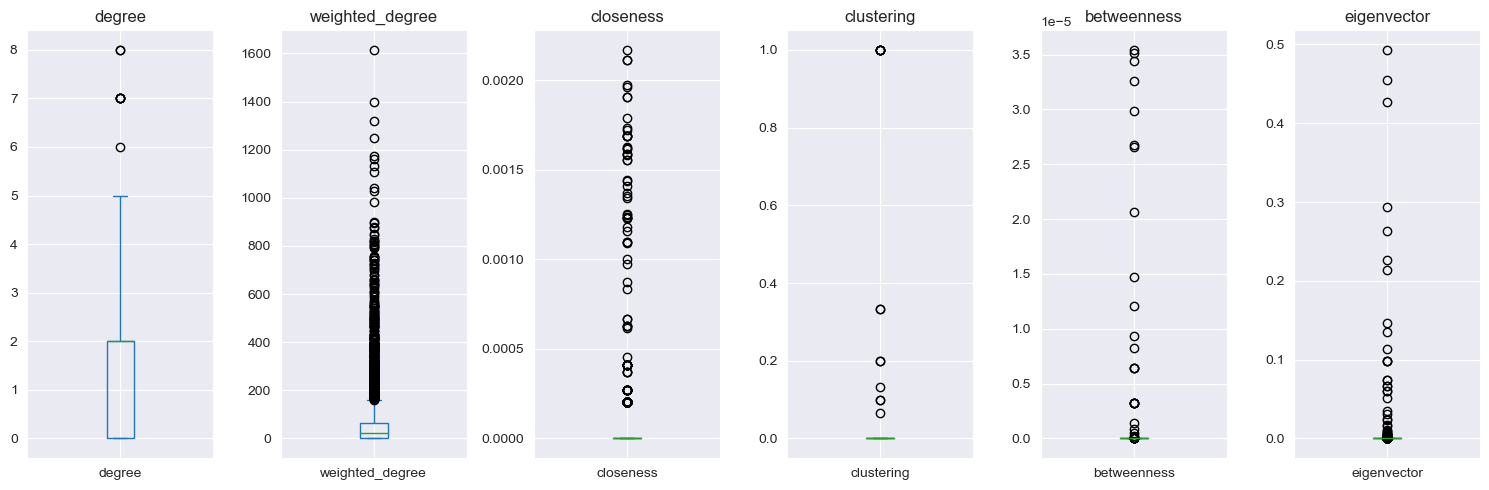

In [20]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(df_attributes.iloc[:, 4:].columns), figsize=(15, 5))

# Plot boxplots for each column
for i, column in enumerate(df_attributes.iloc[:, 4:].columns):
    df_attributes[column].plot(kind='box', ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

In [21]:
import pandas as pd
import community

# Get all connected components
connected_components = nx.connected_components(G)

df = pd.DataFrame()

# For each connected component
for cc in connected_components:
    # Create a subgraph of G consisting only of this component
    Gc = G.subgraph(cc).copy()

    # Calculate metrics for this component
    degree = dict(Gc.degree())
    weighted_degree = dict(Gc.degree(weight='weight'))
    eccentricity = nx.eccentricity(Gc)
    closeness_centrality = nx.closeness_centrality(Gc)
    harmonic_closeness_centrality = nx.harmonic_centrality(Gc)
    betweenness_centrality = nx.betweenness_centrality(Gc)
    partition = community.best_partition(Gc)
    modularity_class = dict(partition)
    clustering = nx.clustering(Gc)
    eigenvector_centrality = nx.eigenvector_centrality(Gc)

    # Create a DataFrame for this component
    df_component = pd.DataFrame({
        'degree': pd.Series(degree),
        'weighted_degree': pd.Series(weighted_degree),
        'eccentricity': pd.Series(eccentricity),
        'closeness_centrality': pd.Series(closeness_centrality),
        'harmonic_closeness_centrality': pd.Series(harmonic_closeness_centrality),
        'betweenness_centrality': pd.Series(betweenness_centrality),
        'modularity_class': pd.Series(modularity_class),
        'clustering': pd.Series(clustering),
        'eigenvector_centrality': pd.Series(eigenvector_centrality)
    })

    df = pd.concat([df, df_component], axis=0)

    df.reset_index(drop=True, inplace=True)

# Save DataFrame to a csv file
#df.to_csv('network_metrics.csv', index=True)
df

,degree,weighted_degree,eccentricity,closeness_centrality,harmonic_closeness_centrality,betweenness_centrality,modularity_class,clustering,eigenvector_centrality
0,2,62,0,0.0,0.0,0.0,0,0.0,1.0
1,0,0,0,0.0,0.0,0.0,0,0.0,1.0
2,2,412,0,0.0,0.0,0.0,0,0.0,1.0
3,2,126,0,0.0,0.0,0.0,0,0.0,1.0
4,2,482,0,0.0,0.0,0.0,0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
4877,0,0,0,0.0,0.0,0.0,0,0.0,1.0
4878,2,8,0,0.0,0.0,0.0,0,0.0,1.0
4879,2,38,0,0.0,0.0,0.0,0,0.0,1.0
4880,0,0,0,0.0,0.0,0.0,0,0.0,1.0


In [22]:
df.max()

degree                              8.000000
weighted_degree                  1615.000000
eccentricity                       15.000000
closeness_centrality                1.000000
harmonic_closeness_centrality      16.016667
betweenness_centrality              1.000000
modularity_class                   12.000000
clustering                          1.000000
eigenvector_centrality              1.000000
dtype: float64

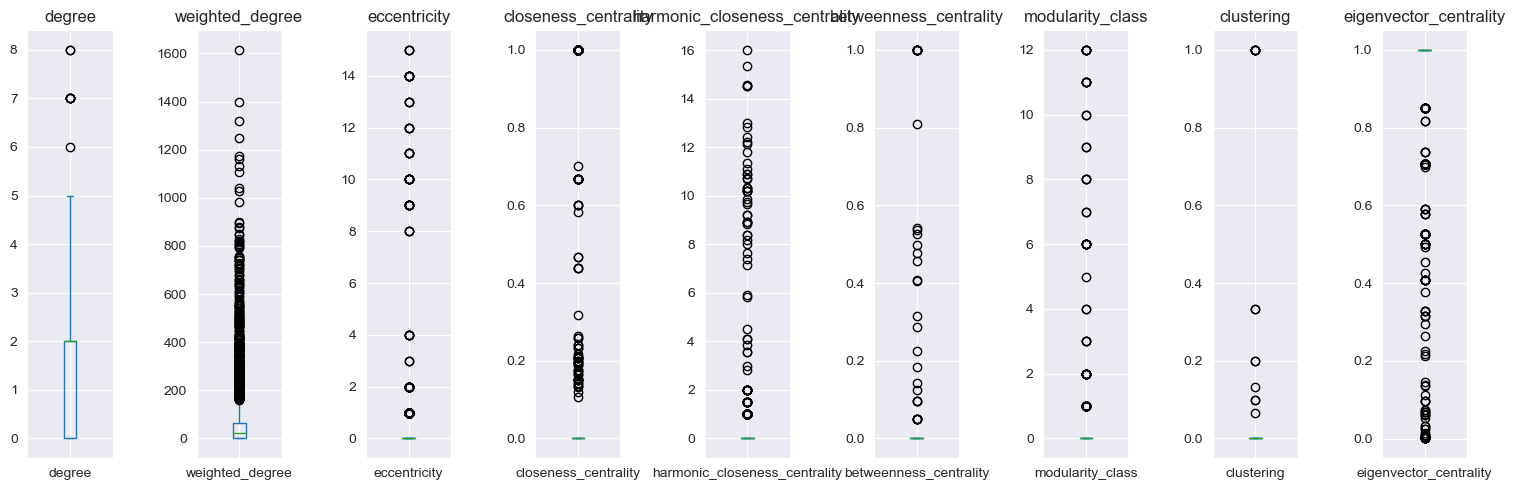

In [23]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(df.columns), figsize=(15, 5))

# Plot boxplots for each column
for i, column in enumerate(df.columns):
    df[column].plot(kind='box', ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()


take a look at betweenness_centrality

normalize:

In [24]:
from sklearn.preprocessing import MinMaxScaler

# Assuming df_nodes is your DataFrame
# Select only the columns to be normalized
columns_to_normalize = df_nodes.columns[5:]  # Exclude the first and last columns
data_to_normalize = df_nodes[columns_to_normalize]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
normalized_data = scaler.fit_transform(data_to_normalize)

# Replace the original data with the normalized values
df_nodes_norm = df_nodes.copy()
df_nodes_norm[columns_to_normalize] = normalized_data

# Print the updated DataFrame
df_nodes_norm


,Node,id,popularity,followers,genres,degree,weighted_degree,closeness,clustering,betweenness,eigenvector
0,NF,6fOMl44jA4Sp5b9PpYCkzz,90,2256060.0,"['hip hop', 'rap']",0.25,0.038390,0.0,0.0,0.0,3.913759e-18
1,Canibus,2lQvoGjN6jJfsAkaywtgrB,43,46773.0,"['battle rap', 'east coast hip hop', 'hardcore...",0.00,0.000000,0.0,0.0,0.0,0.000000e+00
2,Miley Cyrus,5YGY8feqx7naU7z4HrwZM6,87,9615219.0,"['dance pop', 'pop', 'post-teen pop']",0.25,0.255108,0.0,0.0,0.0,3.913759e-18
3,Gavin DeGraw,5DYAABs8rkY9VhwtENoQCz,70,910431.0,"['acoustic pop', 'neo mellow', 'pop', 'pop rock']",0.25,0.078019,0.0,0.0,0.0,3.913759e-18
4,R.E.M.,4KWTAlx2RvbpseOGMEmROg,76,1984742.0,"['alternative rock', 'permanent wave', 'pop ro...",0.25,0.298452,0.0,0.0,0.0,3.913759e-18
...,...,...,...,...,...,...,...,...,...,...,...
4877,Cisco Adler,23apFYuBTpFemqLDn8ViLW,57,12063.0,['indie pop rap'],0.00,0.000000,0.0,0.0,0.0,0.000000e+00
4878,British Lions,79EQ2MmIK2wQakeotwFuNF,6,717.0,[],0.25,0.004954,0.0,0.0,0.0,3.913759e-18
4879,Timex Social Club,1C0HVpji7xDIdGbnsdUwCt,35,2997.0,[],0.25,0.023529,0.0,0.0,0.0,3.913759e-18
4880,Faithless,5T4UKHhr4HGIC0VzdZQtAE,62,330083.0,"['big beat', 'downtempo', 'electronic']",0.00,0.000000,0.0,0.0,0.0,0.000000e+00


In [25]:
#print max value for each coloumn
print("max values:")
print(df_nodes.iloc[:,5:].max())
print(df_nodes_norm.iloc[:,5:].max())

#print min value for each coloumn
print()
print("min values:")
print(df_nodes.iloc[:,5:].min())
print(df_nodes_norm.iloc[:,5:].min())

max values:
degree                8.000000
weighted_degree    1615.000000
closeness             0.002171
clustering            1.000000
betweenness           0.000035
eigenvector           0.493096
dtype: float64
degree             1.0
weighted_degree    1.0
closeness          1.0
clustering         1.0
betweenness        1.0
eigenvector        1.0
dtype: float64

min values:
degree             0.000000e+00
weighted_degree    0.000000e+00
closeness          0.000000e+00
clustering         0.000000e+00
betweenness        0.000000e+00
eigenvector        1.755196e-30
dtype: float64
degree             0.0
weighted_degree    0.0
closeness          0.0
clustering         0.0
betweenness        0.0
eigenvector        0.0
dtype: float64


1/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


2/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


3/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


4/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


5/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


6/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


7/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


8/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


9/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


10/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


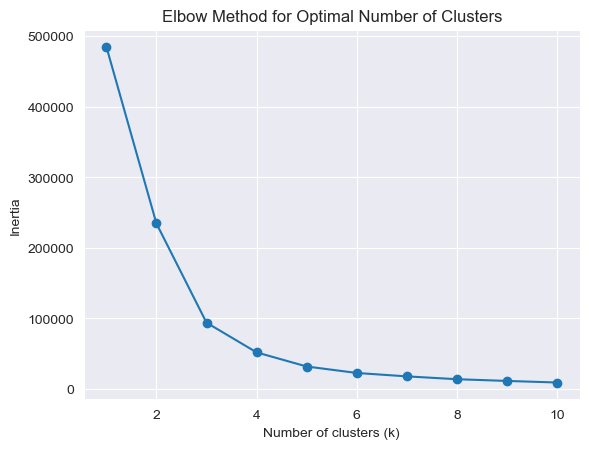

In [26]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import numpy as np

# Assuming df is your DataFrame with node attributes and edge attributes added

# Convert the DataFrame to a sparse adjacency matrix
A_dense = pairwise_distances(df_nodes_norm.iloc[:,5:], metric='euclidean')

# Apply Louvain community detection algorithm to detect communities (if needed)
# You may need to find an alternative community detection algorithm for DataFrame-based graphs

# Calculate the modularity for different values of k
k_values = range(1, 11)  # Adjust the range as needed
inertias = []

amount_k = len(k_values)
for k in k_values:
    print(f'{k}/{amount_k}')
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(A_dense)
    inertia = kmeans.inertia_
    inertias.append(inertia)

# Plot the elbow curve
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()


1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The 

10/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


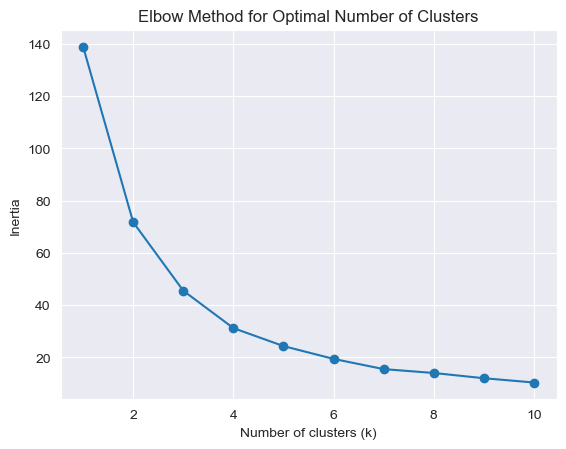

In [27]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import numpy as np

# Assuming df is your DataFrame with node attributes and edge attributes added

# Convert the DataFrame to a sparse adjacency matrix
#A_dense = pairwise_distances(df_nodes.drop(columns=['Node']), metric='euclidean')
A_dense = df_nodes_norm.iloc[:,5:]

# Apply Louvain community detection algorithm to detect communities (if needed)
# You may need to find an alternative community detection algorithm for DataFrame-based graphs

# Calculate the modularity for different values of k
k_values = range(1, 11)  # Adjust the range as needed
inertias = []

amount_k = len(k_values)
for k in k_values:
    print(f'{k}/{amount_k}')
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(A_dense)
    inertia = kmeans.inertia_
    inertias.append(inertia)

# Plot the elbow curve
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()


for unnormalized the results were 3

In [28]:
from sklearn.cluster import KMeans

# Assuming df_nodes is your DataFrame containing node attributes

# Extract the features (attributes) from the DataFrame
X = df_nodes_norm.iloc[:,5:]

# Specify the number of clusters (k)
k = 4  # Adjust as needed

# Initialize KMeans model
kmeans = KMeans(n_clusters=k)

# Fit the model to the data
kmeans.fit(X)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Add cluster labels as a new column in the DataFrame
df_nodes['Cluster'] = cluster_labels
df_nodes_norm['Cluster'] = cluster_labels

# Display the DataFrame with cluster labels
df_nodes


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Node,id,popularity,followers,genres,degree,weighted_degree,closeness,clustering,betweenness,eigenvector,Cluster
0,NF,6fOMl44jA4Sp5b9PpYCkzz,90,2256060.0,"['hip hop', 'rap']",2,62,0.0,0.0,0.0,1.929859e-18,1
1,Canibus,2lQvoGjN6jJfsAkaywtgrB,43,46773.0,"['battle rap', 'east coast hip hop', 'hardcore...",0,0,0.0,0.0,0.0,1.755196e-30,0
2,Miley Cyrus,5YGY8feqx7naU7z4HrwZM6,87,9615219.0,"['dance pop', 'pop', 'post-teen pop']",2,412,0.0,0.0,0.0,1.929859e-18,3
3,Gavin DeGraw,5DYAABs8rkY9VhwtENoQCz,70,910431.0,"['acoustic pop', 'neo mellow', 'pop', 'pop rock']",2,126,0.0,0.0,0.0,1.929859e-18,1
4,R.E.M.,4KWTAlx2RvbpseOGMEmROg,76,1984742.0,"['alternative rock', 'permanent wave', 'pop ro...",2,482,0.0,0.0,0.0,1.929859e-18,3
...,...,...,...,...,...,...,...,...,...,...,...,...
4877,Cisco Adler,23apFYuBTpFemqLDn8ViLW,57,12063.0,['indie pop rap'],0,0,0.0,0.0,0.0,1.755196e-30,0
4878,British Lions,79EQ2MmIK2wQakeotwFuNF,6,717.0,[],2,8,0.0,0.0,0.0,1.929859e-18,1
4879,Timex Social Club,1C0HVpji7xDIdGbnsdUwCt,35,2997.0,[],2,38,0.0,0.0,0.0,1.929859e-18,1
4880,Faithless,5T4UKHhr4HGIC0VzdZQtAE,62,330083.0,"['big beat', 'downtempo', 'electronic']",0,0,0.0,0.0,0.0,1.755196e-30,0


In [29]:
# Assuming df_nodes is your DataFrame with cluster labels

# Calculate the cardinality of each cluster
cluster_cardinality = df_nodes_norm['Cluster'].value_counts()

# Display the cardinality of each cluster
print(cluster_cardinality)


Cluster
1    3143
0    1442
3     253
2      44
Name: count, dtype: int64


In [30]:
##Dimensional reduction:

import pandas as pd
from sklearn.decomposition import PCA

# Assuming df is your DataFrame

# Omit the first and last columns
X = df_nodes_norm.iloc[:,5:-1]

# Initialize PCA with 2 components
pca = PCA(n_components=2)

# Fit and transform the data
X_2d = pca.fit_transform(X)

# Convert the result to a DataFrame
df_2d = pd.DataFrame(X_2d, columns=['Component 1', 'Component 2'])

# Display the resulting DataFrame
df_2d["Node"] = df_nodes["Node"]
df_2d["Cluster"] = df_nodes["Cluster"]
df_2d

,Component 1,Component 2,Node,Cluster
0,0.059806,-0.031491,NF,1
1,-0.180655,0.043157,Canibus,0
2,0.128573,0.014755,Miley Cyrus,3
3,0.072380,-0.023035,Gavin DeGraw,1
4,0.142327,0.024004,R.E.M.,3
...,...,...,...,...
4877,-0.180655,0.043157,Cisco Adler,0
4878,0.049196,-0.038626,British Lions,1
4879,0.055090,-0.034662,Timex Social Club,1
4880,-0.180655,0.043157,Faithless,0


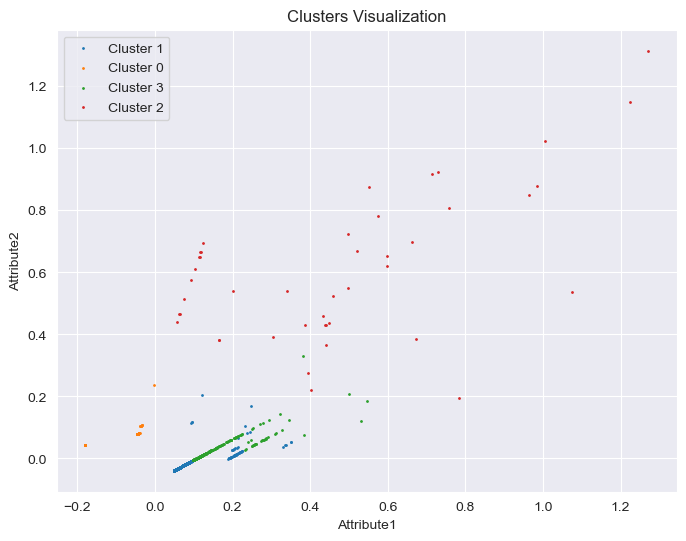

In [31]:
import matplotlib.pyplot as plt

# Assuming df_nodes is your DataFrame with cluster labels

# Plot the clusters in a scatter plot
plt.figure(figsize=(8, 6))

# Iterate over unique cluster labels
for cluster_label in df_2d['Cluster'].unique():
    # Filter the DataFrame for nodes in the current cluster
    df_cluster = df_2d[df_2d['Cluster'] == cluster_label]
    # Plot the nodes in the cluster
    plt.scatter(df_cluster["Component 1"], df_cluster["Component 2"], s=1, label=f'Cluster {cluster_label}')

# Add labels and title
plt.xlabel('Attribute1')
plt.ylabel('Attribute2')
plt.title('Clusters Visualization')

# Add legend
plt.legend()

# Show plot
plt.show()


In [32]:
radar_df = df_nodes_norm.copy()
features = radar_df.columns[5:-1]
print((features))
for feature in features:
    radar_df[feature] = (radar_df[feature] >= 0.5).astype(int)
    
radar_df

Index(['degree', 'weighted_degree', 'closeness', 'clustering', 'betweenness',
       'eigenvector'],
      dtype='object')


,Node,id,popularity,followers,genres,degree,weighted_degree,closeness,clustering,betweenness,eigenvector,Cluster
0,NF,6fOMl44jA4Sp5b9PpYCkzz,90,2256060.0,"['hip hop', 'rap']",0,0,0,0,0,0,1
1,Canibus,2lQvoGjN6jJfsAkaywtgrB,43,46773.0,"['battle rap', 'east coast hip hop', 'hardcore...",0,0,0,0,0,0,0
2,Miley Cyrus,5YGY8feqx7naU7z4HrwZM6,87,9615219.0,"['dance pop', 'pop', 'post-teen pop']",0,0,0,0,0,0,3
3,Gavin DeGraw,5DYAABs8rkY9VhwtENoQCz,70,910431.0,"['acoustic pop', 'neo mellow', 'pop', 'pop rock']",0,0,0,0,0,0,1
4,R.E.M.,4KWTAlx2RvbpseOGMEmROg,76,1984742.0,"['alternative rock', 'permanent wave', 'pop ro...",0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
4877,Cisco Adler,23apFYuBTpFemqLDn8ViLW,57,12063.0,['indie pop rap'],0,0,0,0,0,0,0
4878,British Lions,79EQ2MmIK2wQakeotwFuNF,6,717.0,[],0,0,0,0,0,0,1
4879,Timex Social Club,1C0HVpji7xDIdGbnsdUwCt,35,2997.0,[],0,0,0,0,0,0,1
4880,Faithless,5T4UKHhr4HGIC0VzdZQtAE,62,330083.0,"['big beat', 'downtempo', 'electronic']",0,0,0,0,0,0,0


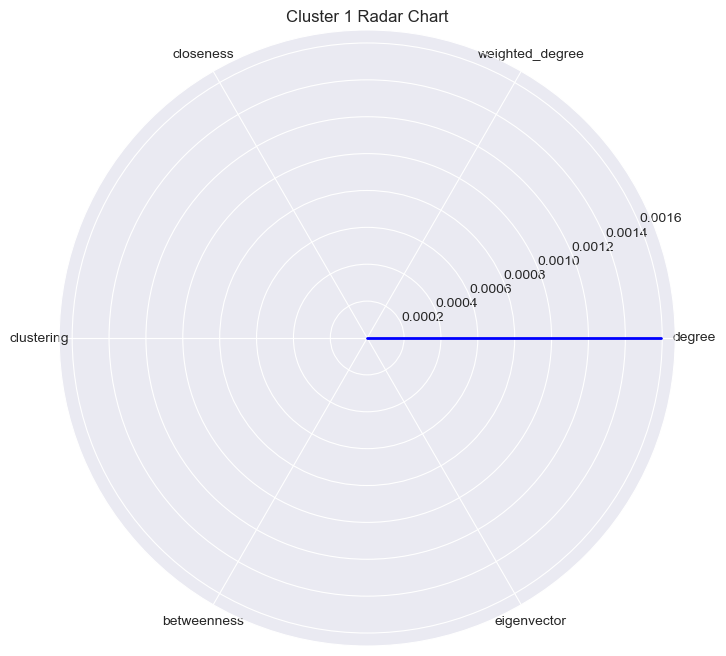

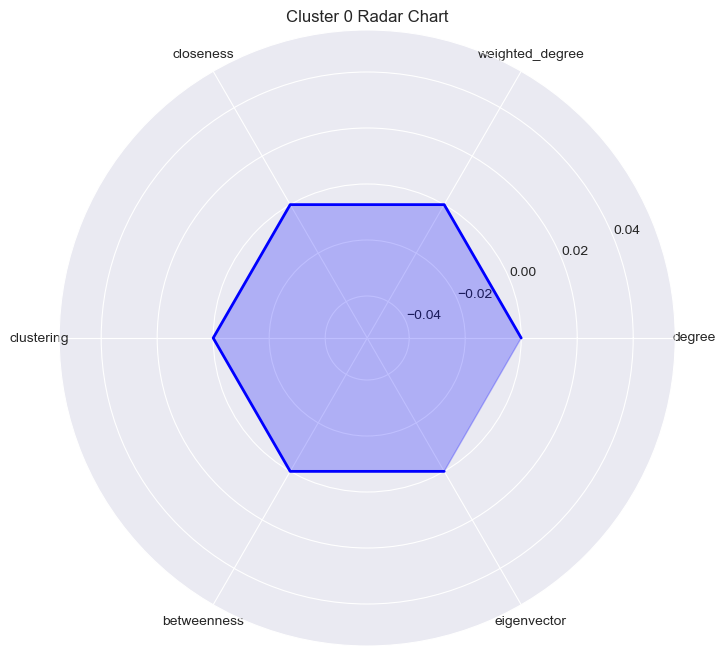

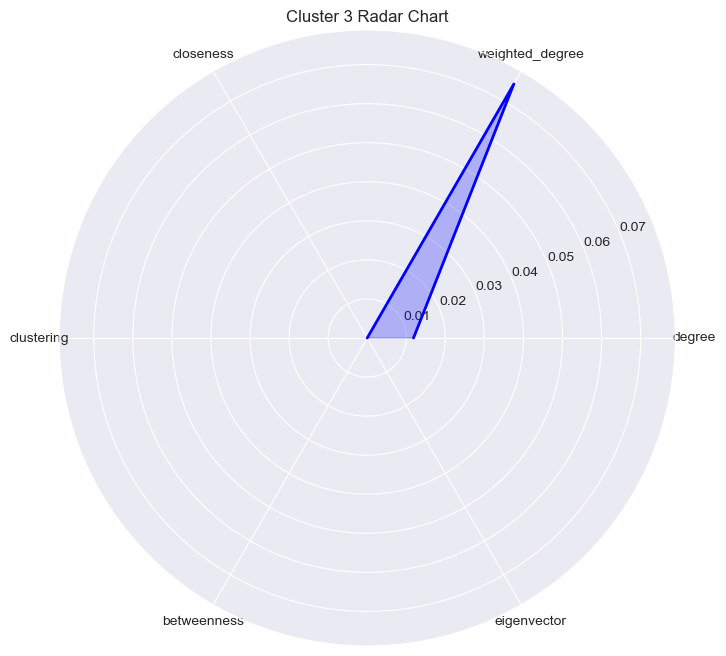

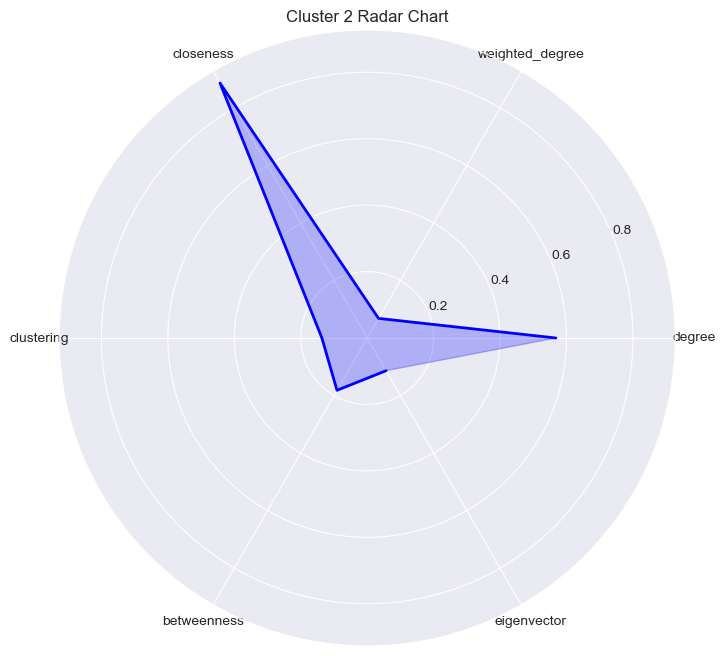

In [33]:
import numpy as np
import matplotlib.pyplot as plt

#for radar charts values to 1 if 0.5 or higher, rest to 0?
#######Profiles?##########

# Define the attributes for the radar chart
attributes = radar_df.iloc[:,5:-1].columns.tolist()

# Define the theta values (angles) for each attribute
theta = np.linspace(0, 2 * np.pi, len(attributes), endpoint=False)

# Iterate over each unique cluster label
for cluster_label in radar_df['Cluster'].unique():
    # Create a figure and add a subplot with polar projection for each cluster
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Filter the DataFrame for the current cluster
    cluster_data = radar_df[radar_df['Cluster'] == cluster_label]

    # Get attribute values for the current cluster
    values = cluster_data.iloc[:,5:-1].mean(axis=0).tolist()

    # Repeat the first value to close the plot
    #values += values[:1]

    # Plot the radar chart
    ax.fill(theta, values, color='blue', alpha=0.25)
    ax.plot(theta, values, color='blue', linewidth=2)

    # Set the labels for each attribute
    ax.set_xticks(theta)
    ax.set_xticklabels(attributes)

    # Set the title for the radar chart
    ax.set_title(f'Cluster {cluster_label} Radar Chart')

    # Show plot
    plt.show()


all makes more sense for not norm? 
=> take a look at init of graph and change?
=> not really successsfull


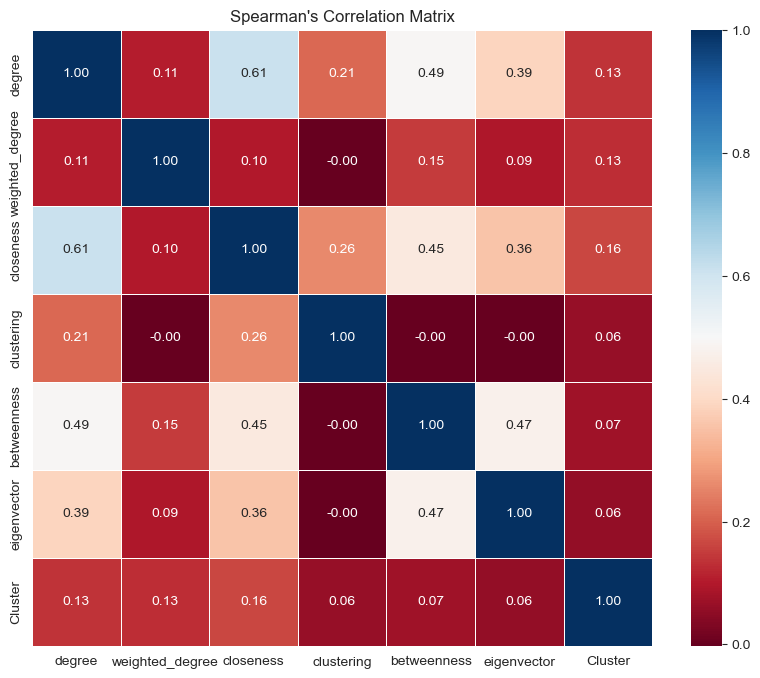

In [34]:
import seaborn as sns

# Compute Spearman's correlation matrix
corr_matrix = radar_df.iloc[:,5:].corr(method='spearman')

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt=".2f", linewidths=0.5)
plt.title("Spearman's Correlation Matrix")
plt.show()


=> pca(5) then clustering?

ziemlich unterschiedlich zur vorlage???
versuche exakte Nachimplementierung

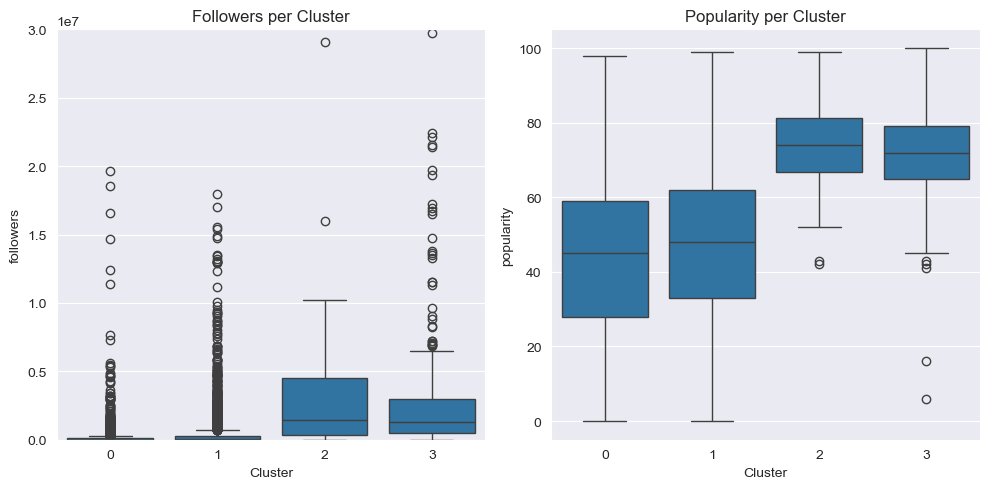

In [35]:
# Plot boxplots for followers and popularity per cluster
plt.figure(figsize=(10, 5))

# Boxplot for followers per cluster
plt.subplot(1, 2, 1)
sns.boxplot(x='Cluster', y='followers', data=df_nodes_norm)
plt.ylim(0, 30000000)
plt.title('Followers per Cluster')

# Boxplot for popularity per cluster
plt.subplot(1, 2, 2)
sns.boxplot(x='Cluster', y='popularity', data=df_nodes_norm)
plt.title('Popularity per Cluster')

plt.tight_layout()
plt.show()

Abgrenzung ist nicht ganz so stark, allerdings dennoch substantiell, dies liegt vermutlich daran, dass wir alle genommen haben.

evtl Versuch nur als erfolgreich definierte zu nehmen.

Abgrenzung ist grundsätzlich nicht so stark für unnormalisiert, näher an Paper

## Density based Clustering:

In [36]:
df_nodes_norm

,Node,id,popularity,followers,genres,degree,weighted_degree,closeness,clustering,betweenness,eigenvector,Cluster
0,NF,6fOMl44jA4Sp5b9PpYCkzz,90,2256060.0,"['hip hop', 'rap']",0.25,0.038390,0.0,0.0,0.0,3.913759e-18,1
1,Canibus,2lQvoGjN6jJfsAkaywtgrB,43,46773.0,"['battle rap', 'east coast hip hop', 'hardcore...",0.00,0.000000,0.0,0.0,0.0,0.000000e+00,0
2,Miley Cyrus,5YGY8feqx7naU7z4HrwZM6,87,9615219.0,"['dance pop', 'pop', 'post-teen pop']",0.25,0.255108,0.0,0.0,0.0,3.913759e-18,3
3,Gavin DeGraw,5DYAABs8rkY9VhwtENoQCz,70,910431.0,"['acoustic pop', 'neo mellow', 'pop', 'pop rock']",0.25,0.078019,0.0,0.0,0.0,3.913759e-18,1
4,R.E.M.,4KWTAlx2RvbpseOGMEmROg,76,1984742.0,"['alternative rock', 'permanent wave', 'pop ro...",0.25,0.298452,0.0,0.0,0.0,3.913759e-18,3
...,...,...,...,...,...,...,...,...,...,...,...,...
4877,Cisco Adler,23apFYuBTpFemqLDn8ViLW,57,12063.0,['indie pop rap'],0.00,0.000000,0.0,0.0,0.0,0.000000e+00,0
4878,British Lions,79EQ2MmIK2wQakeotwFuNF,6,717.0,[],0.25,0.004954,0.0,0.0,0.0,3.913759e-18,1
4879,Timex Social Club,1C0HVpji7xDIdGbnsdUwCt,35,2997.0,[],0.25,0.023529,0.0,0.0,0.0,3.913759e-18,1
4880,Faithless,5T4UKHhr4HGIC0VzdZQtAE,62,330083.0,"['big beat', 'downtempo', 'electronic']",0.00,0.000000,0.0,0.0,0.0,0.000000e+00,0


In [37]:
from sklearn.cluster import DBSCAN

# Assuming df_nodes is your DataFrame containing node attributes

# Extract the features (attributes) from the DataFrame
X = df_nodes_norm.iloc[:, 5:-1]  # Assuming your features start from column index 5

# Initialize DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed

# Fit the model to the data
dbscan.fit(X)

# Get the cluster labels
cluster_labels = dbscan.labels_

# Add cluster labels as a new column in the DataFrame
df_nodes['Cluster'] = cluster_labels
df_nodes_norm['Cluster'] = cluster_labels

# Display the DataFrame with cluster labels
df_nodes


,Node,id,popularity,followers,genres,degree,weighted_degree,closeness,clustering,betweenness,eigenvector,Cluster
0,NF,6fOMl44jA4Sp5b9PpYCkzz,90,2256060.0,"['hip hop', 'rap']",2,62,0.0,0.0,0.0,1.929859e-18,0
1,Canibus,2lQvoGjN6jJfsAkaywtgrB,43,46773.0,"['battle rap', 'east coast hip hop', 'hardcore...",0,0,0.0,0.0,0.0,1.755196e-30,0
2,Miley Cyrus,5YGY8feqx7naU7z4HrwZM6,87,9615219.0,"['dance pop', 'pop', 'post-teen pop']",2,412,0.0,0.0,0.0,1.929859e-18,0
3,Gavin DeGraw,5DYAABs8rkY9VhwtENoQCz,70,910431.0,"['acoustic pop', 'neo mellow', 'pop', 'pop rock']",2,126,0.0,0.0,0.0,1.929859e-18,0
4,R.E.M.,4KWTAlx2RvbpseOGMEmROg,76,1984742.0,"['alternative rock', 'permanent wave', 'pop ro...",2,482,0.0,0.0,0.0,1.929859e-18,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4877,Cisco Adler,23apFYuBTpFemqLDn8ViLW,57,12063.0,['indie pop rap'],0,0,0.0,0.0,0.0,1.755196e-30,0
4878,British Lions,79EQ2MmIK2wQakeotwFuNF,6,717.0,[],2,8,0.0,0.0,0.0,1.929859e-18,0
4879,Timex Social Club,1C0HVpji7xDIdGbnsdUwCt,35,2997.0,[],2,38,0.0,0.0,0.0,1.929859e-18,0
4880,Faithless,5T4UKHhr4HGIC0VzdZQtAE,62,330083.0,"['big beat', 'downtempo', 'electronic']",0,0,0.0,0.0,0.0,1.755196e-30,0


In [38]:
# Assuming df_nodes is your DataFrame with cluster labels

# Calculate the cardinality of each cluster
cluster_cardinality = df_nodes_norm['Cluster'].value_counts()

# Display the cardinality of each cluster
print(cluster_cardinality)


Cluster
 0    4867
-1      10
 1       5
Name: count, dtype: int64


In [39]:
##Dimensional reduction:

import pandas as pd
from sklearn.decomposition import PCA

# Assuming df is your DataFrame

# Omit the first and last columns
X = df_nodes_norm.iloc[:,5:-1]

# Initialize PCA with 2 components
pca = PCA(n_components=2)

# Fit and transform the data
X_2d = pca.fit_transform(X)

# Convert the result to a DataFrame
df_2d = pd.DataFrame(X_2d, columns=['Component 1', 'Component 2'])

# Display the resulting DataFrame
df_2d["Node"] = df_nodes["Node"]
df_2d["Cluster"] = df_nodes["Cluster"]
df_2d

,Component 1,Component 2,Node,Cluster
0,0.059806,-0.031491,NF,0
1,-0.180655,0.043157,Canibus,0
2,0.128573,0.014755,Miley Cyrus,0
3,0.072380,-0.023035,Gavin DeGraw,0
4,0.142327,0.024004,R.E.M.,0
...,...,...,...,...
4877,-0.180655,0.043157,Cisco Adler,0
4878,0.049196,-0.038626,British Lions,0
4879,0.055090,-0.034662,Timex Social Club,0
4880,-0.180655,0.043157,Faithless,0


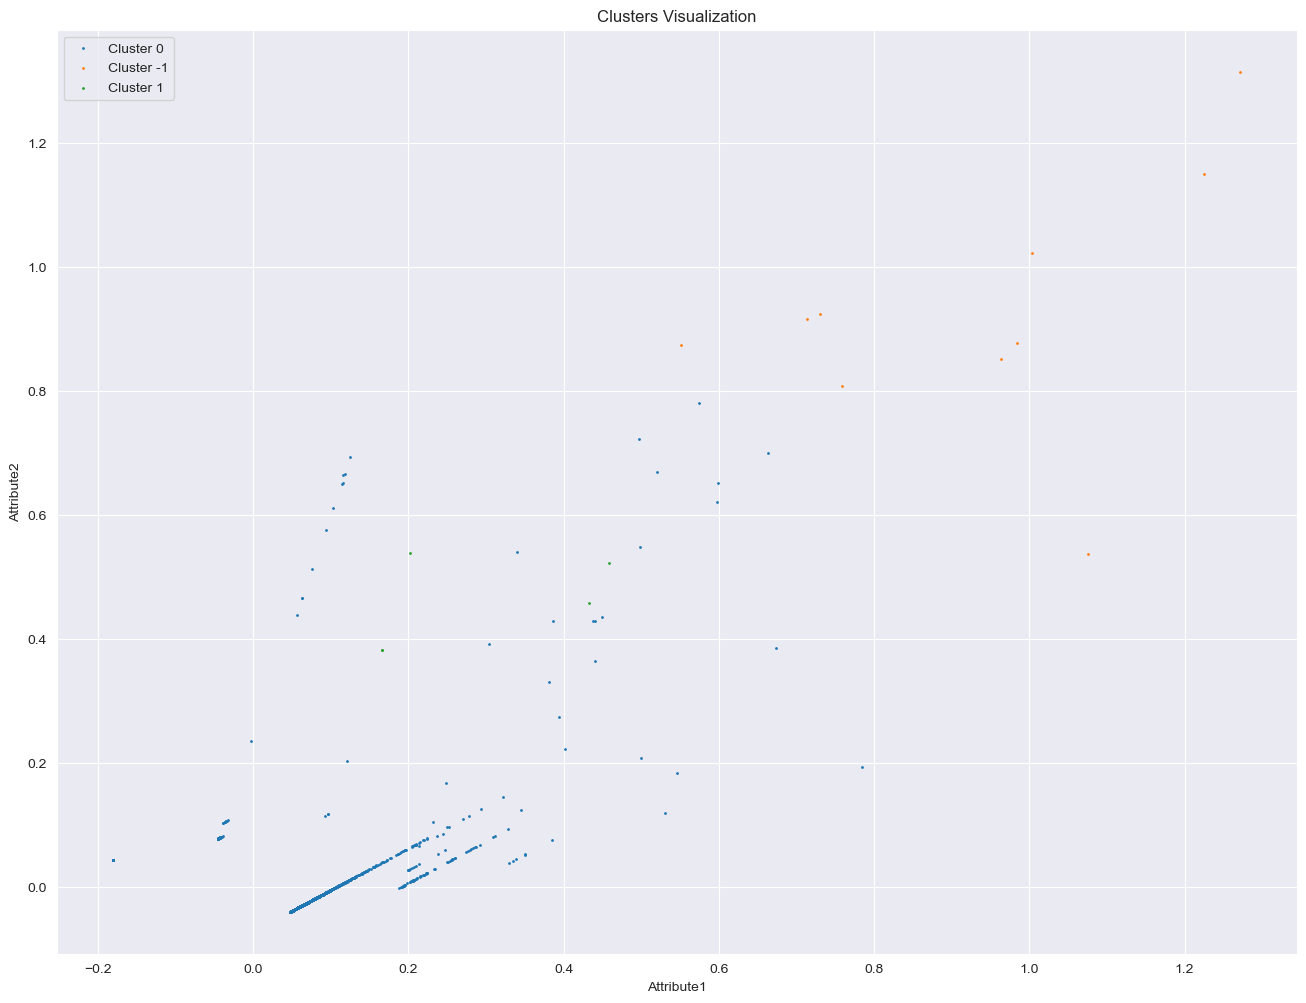

In [40]:
import matplotlib.pyplot as plt

# Assuming df_nodes is your DataFrame with cluster labels

# Plot the clusters in a scatter plot
plt.figure(figsize=(16, 12))

# Iterate over unique cluster labels
for cluster_label in df_2d['Cluster'].unique():
    # Filter the DataFrame for nodes in the current cluster
    df_cluster = df_2d[df_2d['Cluster'] == cluster_label]
    # Plot the nodes in the cluster
    plt.scatter(df_cluster["Component 1"], df_cluster["Component 2"], s=1, label=f'Cluster {cluster_label}')

# Add labels and title
plt.xlabel('Attribute1')
plt.ylabel('Attribute2')
plt.title('Clusters Visualization')

# Add legend
plt.legend()

# Show plot
plt.show()


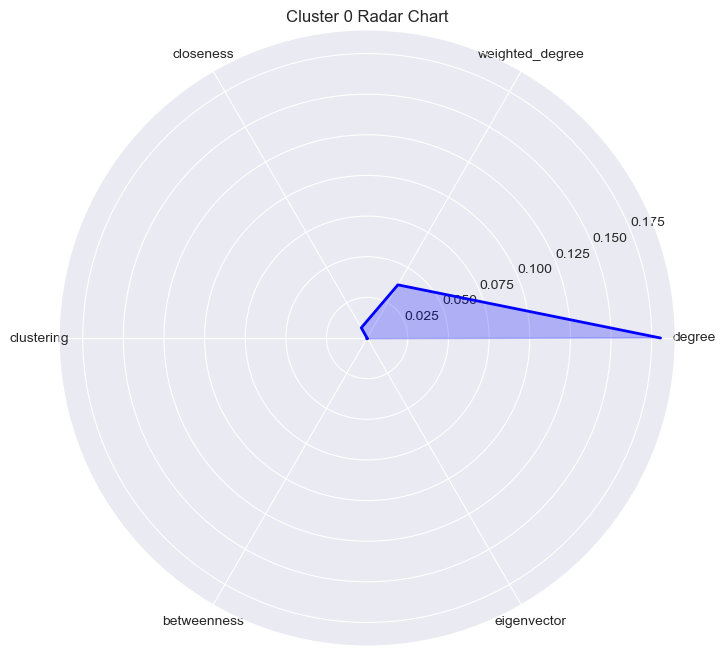

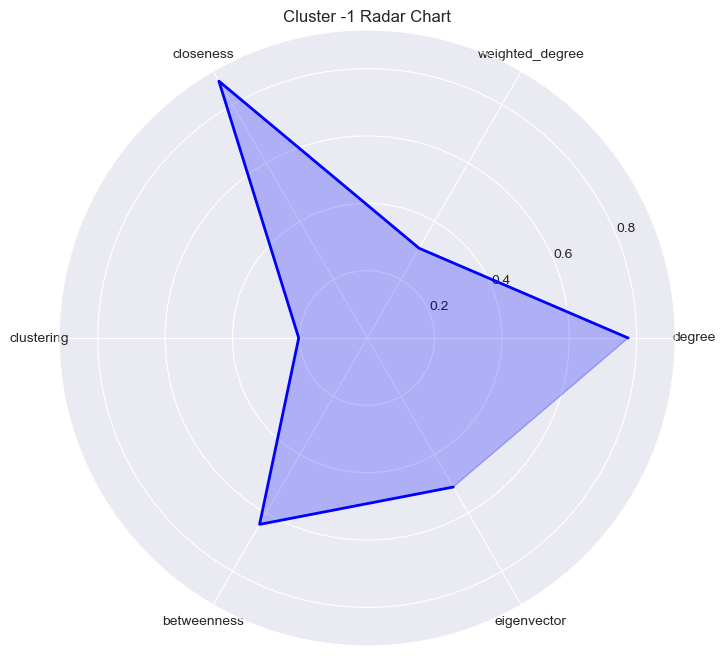

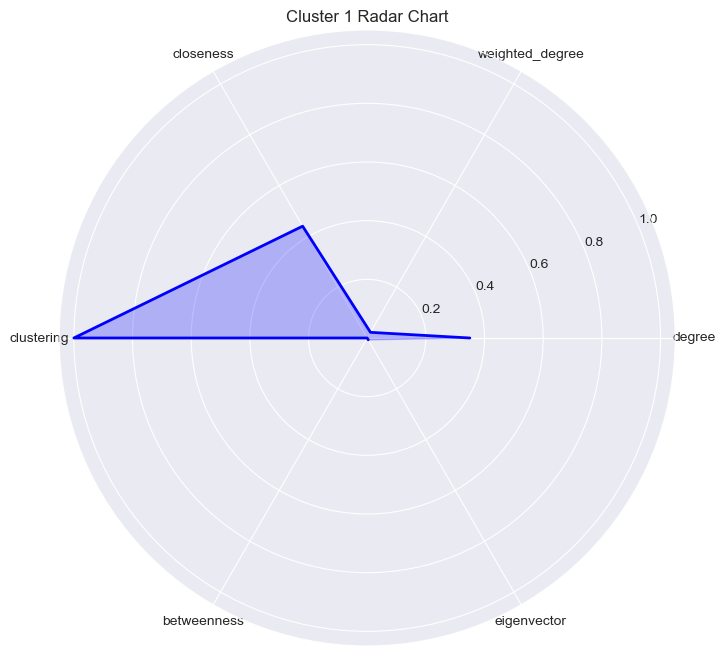

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Define the attributes for the radar chart
attributes = df_nodes_norm.iloc[:,5:-1].columns.tolist()

# Define the theta values (angles) for each attribute
theta = np.linspace(0, 2 * np.pi, len(attributes), endpoint=False)

# Iterate over each unique cluster label
for cluster_label in df_nodes_norm['Cluster'].unique():
    # Create a figure and add a subplot with polar projection for each cluster
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Filter the DataFrame for the current cluster
    cluster_data = df_nodes_norm[df_nodes_norm['Cluster'] == cluster_label]

    # Get attribute values for the current cluster
    values = cluster_data.iloc[:,5:-1].mean(axis=0).tolist()

    # Repeat the first value to close the plot
    #values += values[:1]

    # Plot the radar chart
    ax.fill(theta, values, color='blue', alpha=0.25)
    ax.plot(theta, values, color='blue', linewidth=2)

    # Set the labels for each attribute
    ax.set_xticks(theta)
    ax.set_xticklabels(attributes)

    # Set the title for the radar chart
    ax.set_title(f'Cluster {cluster_label} Radar Chart')

    # Show plot
    plt.show()


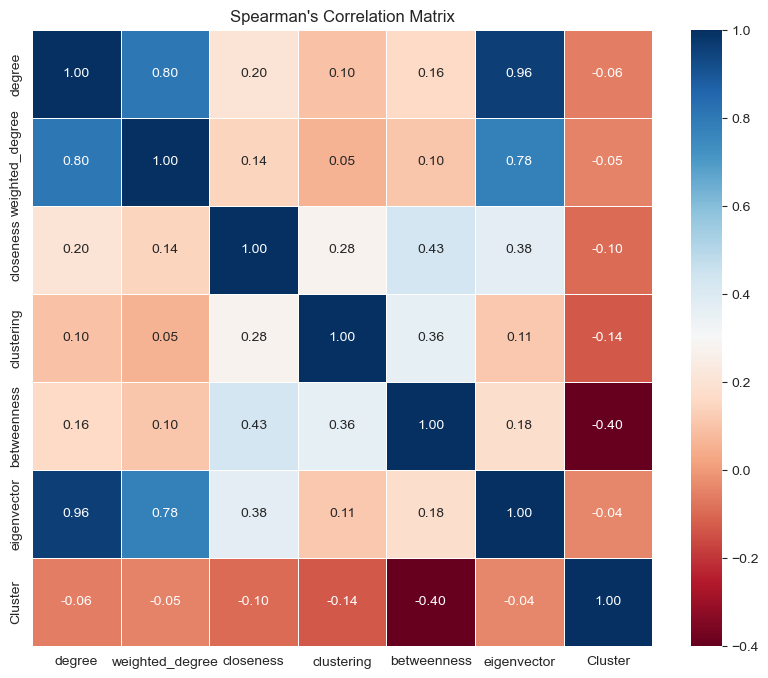

In [42]:
import seaborn as sns

# Compute Spearman's correlation matrix
corr_matrix = df_nodes.iloc[:,5:].corr(method='spearman') 

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt=".2f", linewidths=0.5)
plt.title("Spearman's Correlation Matrix")
plt.show()


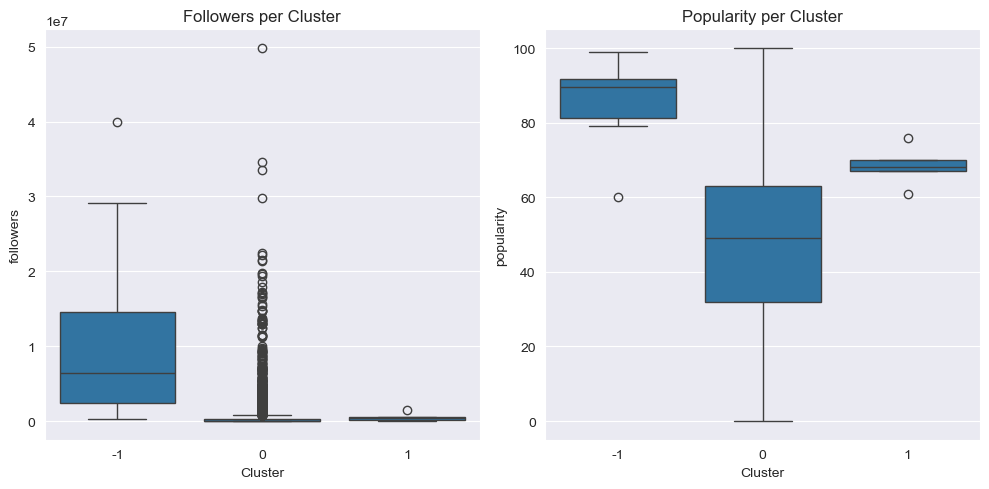

In [43]:
# Plot boxplots for followers and popularity per cluster
plt.figure(figsize=(10, 5))

# Boxplot for followers per cluster
plt.subplot(1, 2, 1)
sns.boxplot(x='Cluster', y='followers', data=df_nodes_norm)
plt.title('Followers per Cluster')

# Boxplot for popularity per cluster
plt.subplot(1, 2, 2)
sns.boxplot(x='Cluster', y='popularity', data=df_nodes_norm)
plt.title('Popularity per Cluster')

plt.tight_layout()
plt.show()